Notebook adaptado del curso “Diplomatura en Inteligencia Artificial y Ciencia de Datos” dictado por la ECyT-UNSAM en el marco del plan Argentina Programa 4.0

# Convolutional Neural Networks (CNN)

Vamos a repasar un poco el tema de las CNN y ver como trabajarlas con Keras, primero bajemos un dataset para hacer unas pruebas.

# Datos: _Canadian Institute For Advanced Research_ - CIFAR10


Es una colección de imágenes que se usan comúnmente para entrenar algoritmos de aprendizaje automático y visión por computadora.
Conjunto de 60.000 imágenes en color de 32x32 pixeles dividada en 10 clases.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#The stars
import tensorflow as tf
from tensorflow import keras

In [2]:
cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

In [3]:
print(X_train_full.shape,y_train_full.shape,X_test.shape,y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [4]:
#Acuerdense que las imágenes a color tienen tres canales, uno para los valores de los píxeles en cada color primario
#primer canal...
X_train_full[0,:,:,0]

array([[ 59,  43,  50, ..., 158, 152, 148],
       [ 16,   0,  18, ..., 123, 119, 122],
       [ 25,  16,  49, ..., 118, 120, 109],
       ...,
       [208, 201, 198, ..., 160,  56,  53],
       [180, 173, 186, ..., 184,  97,  83],
       [177, 168, 179, ..., 216, 151, 123]], dtype=uint8)

Al igual que ya nos pasaba con las redes totalmente conectadas, hacer CrossValidation puede ser muy costoso, así que vamos a usar un conjunto de validación para detectar cuando estemos overfitteando.

De paso también normalizamos los píxeles (que van de 0 a 255) para que estén entre 0 y 1.

In [5]:
#Separo en entrenamiento y validacion, y normalizo los pixeles
#tambien se puede usar train_test_split
X_valid, X_train = X_train_full[:10000] / 255., X_train_full[10000:] / 255.
y_valid, y_train = y_train_full[:10000], y_train_full[10000:]
X_test = X_test / 255.

(50000, 32, 32, 3)


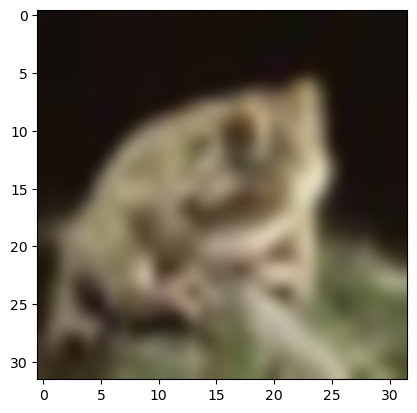

In [7]:
print(X_train_full.shape)

plt.imshow(X_train[1], cmap='binary', interpolation='bicubic')
plt.show()

Los targets son numericos, del 0 al 9. Podemos guardar las etiquetas asi nos es más facil analizar que tan bien o mal funciona nuestro modelo:

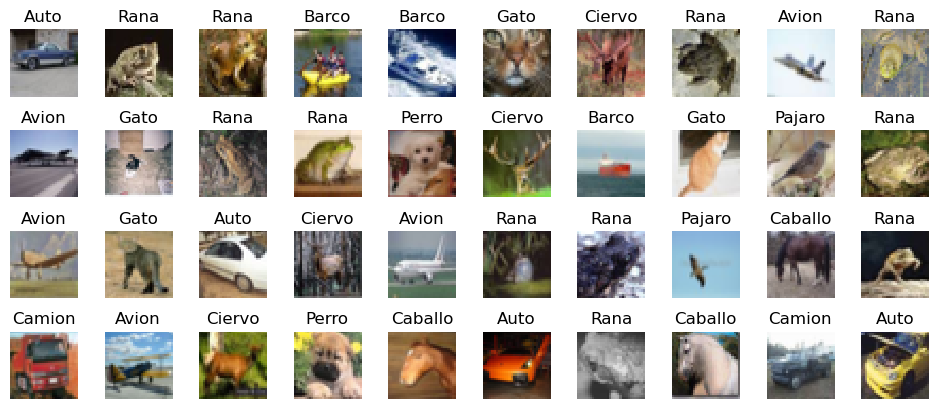

In [8]:
class_names = ["Avion", "Auto", "Pajaro", "Gato","Ciervo", "Perro", "Rana", "Caballo", "Barco", "Camion"]

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index][0]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Repasemos los fundamentos de las CNNs

Como mencionamos en clases anteriores y repasamos en la presentación, si bien una red totalmente conectada suele funcionar bien para muchos casos, cuando se quiere trabajar con imágenes (u otras entradas donde haya alguna  "correlación espacial" entre los elementos) suelen tener una performance subóptima, no es que no funcionen simplemente no son tan buenas. Muchas veces esto sucede porque, justamente, la DNN no tiene en cuenta esta correlación.
En una imagen un píxel está relacionado con los píxeles que lo rodean, y esta información la DNN la está perdiendo, otro tema es que (como vieron con MNIST) el número de parámetros crece con el tamaño de la imagen y con más parámetros es más propensa al overfitting.

Las redes convolucionales atacan estos dos problemas, tienen en cuenta la correlación espacial y el uso de pesos compartidos por cada capa ayudan con la cantidad de parámetros entrenables.

Nacieron para trabajar con imágenes y probablemente sea su uso más extendido (y es el que veremos en el notebook), pero pueden servir para texto, series temporales, datos secuenciales o cualquier entrada que tenga esta "correlación espacial".

Vimos que se definen las dimensiones de un kernel, que esta matriz va aprendiendo sus pesos para que, al convolucionarlo sobre la imagen (o la capa anterior), aprenda diferentes características, etc.

Recordemos que dependiendo del tamaño de la imagen y del kernel quizás querramos rellenarla (padding):


Uno empieza [dibujando](https://www.youtube.com/watch?v=nyZw85q0kRQ) con una imagen de 3x4 (la notación será siempre filas x columnas)
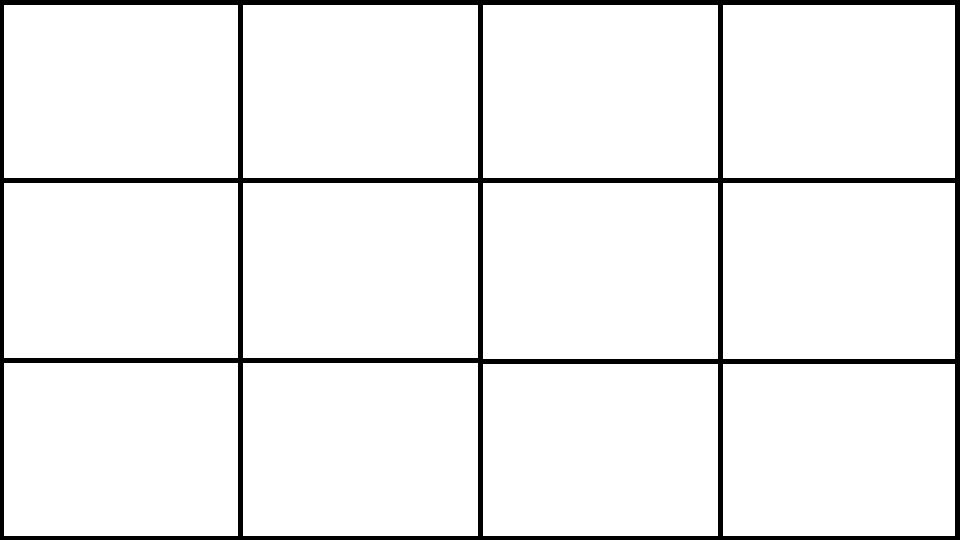

De esa imagen, vamos a seleccionar siempre de a un subconjunto (o ventana) que caracterizaremos por el numero de filas y de columnas consideradas [$f_h$,$f_w$] donde h viene de altura _height_ y w de anchura _width_.

Para nuestro ejemplo, podemos tomar ventanas de [2,2]. La primera de esas ventanas se ve en esta imagen:

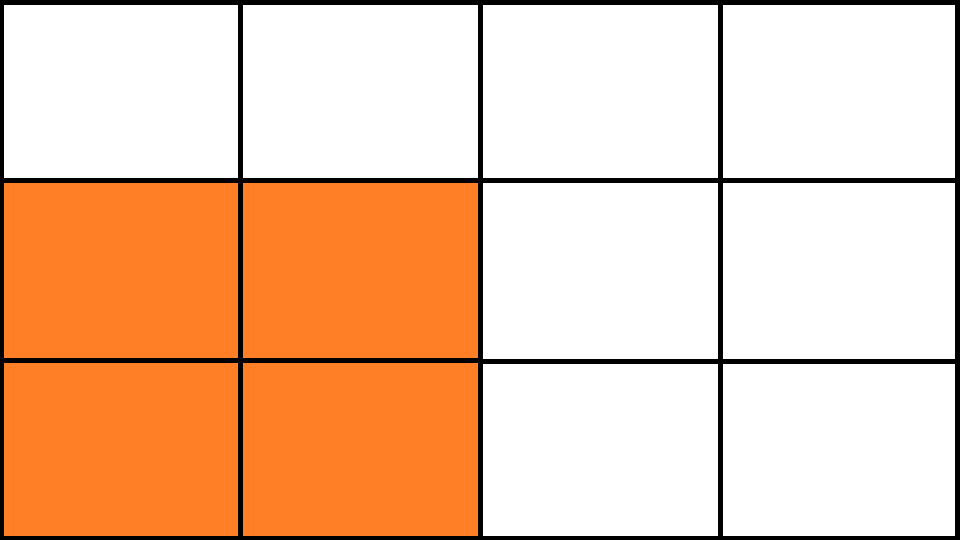

Una vez elegida la ventana, hay que elegir la superposicion entre ventanas. Esto se establece determinando la separacion en filas y en columnas entre ventanas. A estos dos parametros se los llama _stride height_ y _stride width_ [$s_h$,$s_w$], Se los toma de a uno a la vez.

Por ejemplo, tomando [2,2], obtenemos la segunda ventana en la direccion de las columnas facilmente.

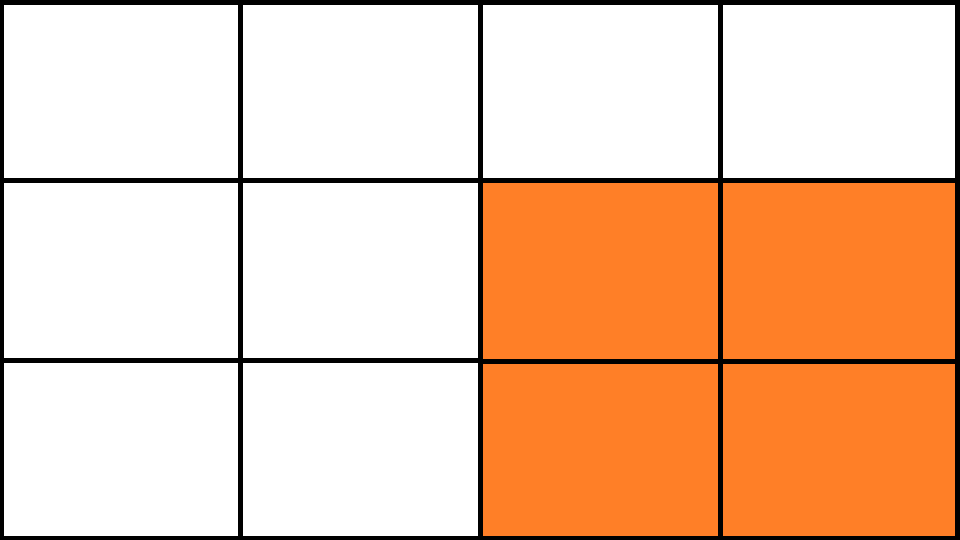

En la direccion de las filas sin embargo, tenemos un problema. Debido a $s_h$,$f_h$, la segunda ventana parece incompleta pero tambien hay datos no utilizados antes (esto no hubiese pasado si tomabamos por ejemplo $f_h = 2$, $s_h = 1$).

Frente a esto, tenemos dos opciones de "padding". En una, que sera "VALID" en tensorflow, simplemente no consideramos los datos que quedan afuera.

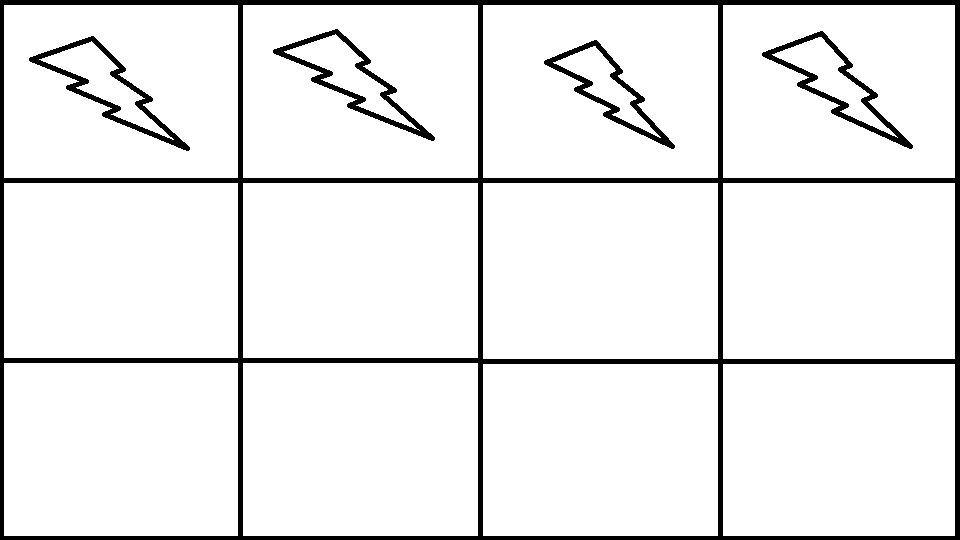

En la otra, llamada "SAME", ampliamos la imagen con ceros hasta que tenga el tamaño adecuado (en particular sera de shape $([H/s_h],[W/s_w])$) donde $[.]$ es la parte entera). La imagen en si no es representativo de como lo llenaria de ceros TensorFlow.

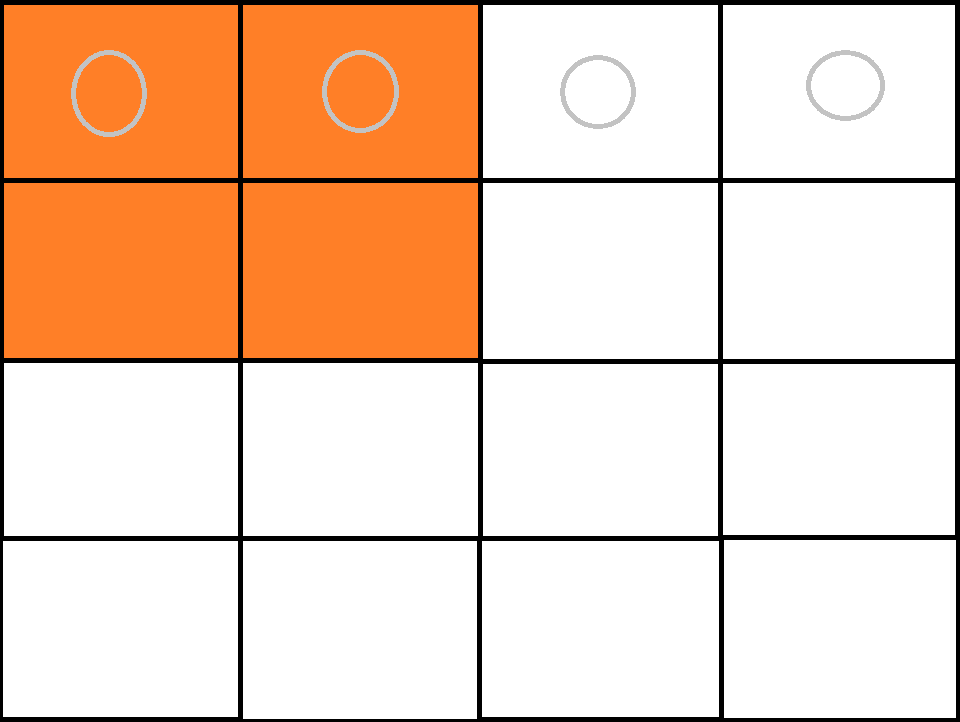


Finalmente, tras samplear con padding="SAME" uno obtiene la siguiente imagen:

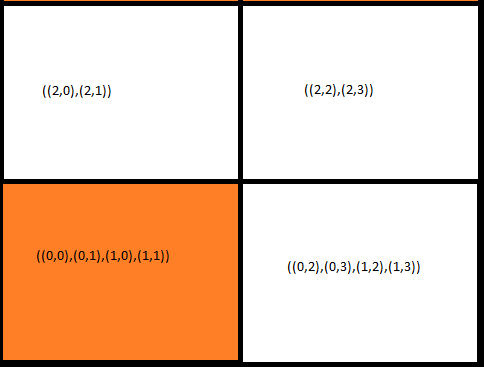


En particular, este tipo de sampleo se implementa en dos ladrillos basicos que agregan las CNNs.
* Los filtros y como estos definen capas convolucionales (Convolutional Layers).
* La capa de pooling (Pooling Layer).

### Filtros y Capa Convolucional

Un filtro clásico es una ventana que posee 0s y 1s en determinados pixeles. Una capa que consiste en un filtro que se mueve por toda la imagen se llama _feature map_. Mostremos como queda una imagen después de aplicar dos filtros clásicos, uno que resalta lineas verticales y otro las horizontales.

Esto lo preparo para aplicar el filtro

In [9]:
index = 5

images = X_train[index]
height, width, channels = images.shape

Estos son los dos filtros, pensando una ventana de (3,3).

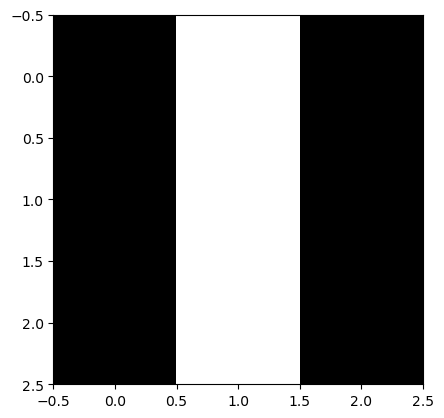

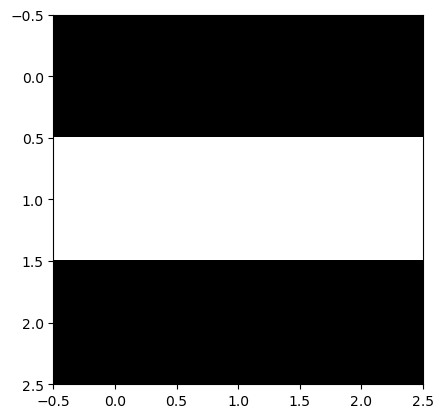

In [10]:
filters = np.zeros(shape=(3, 3, channels, 2), dtype=np.float32)#presten atencion al shape
filters[:, 1, :, 0] = 1  # filtro vertical
filters[1, :, :, 1] = 1  # filtro horizontal
plt.imshow(filters[:, :, 0, 0], cmap="gray", interpolation="nearest")
plt.show()
plt.imshow(filters[:, :, 0, 1], cmap="gray", interpolation="nearest")
plt.show()

Y aplicandolos...  (tomo un codigo del Geron, luego vamos a hacer todo con API Funcional)


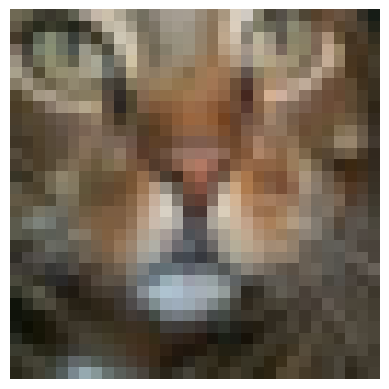

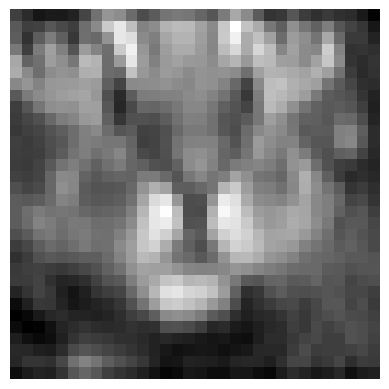

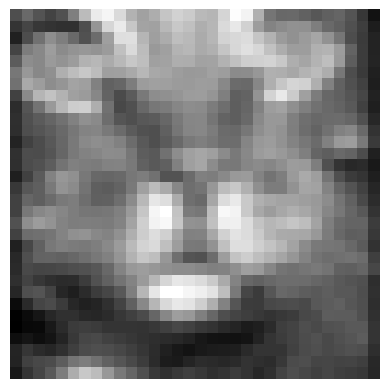

In [11]:
outputs = tf.nn.conv2d(images.reshape(1,height,width,channels), filters, strides=1, padding="SAME")
plt.imshow(images, cmap="binary", interpolation="nearest")
plt.axis("off") # Not shown in the book
plt.show()
plt.imshow(outputs[0, :, :, 0], cmap="gray") # Aplico el primer filtro
plt.axis("off") # Not shown in the book
plt.show()
plt.imshow(outputs[0, :, :, 1], cmap="gray") # Aplico el segundo filtro
plt.axis("off") # Not shown in the book
plt.show()

In [12]:
outputs.shape

TensorShape([1, 32, 32, 2])

**Importante:**

Algo que se evidencia aca es que si bien el input es de shape (1,32,32,3), el output tiene shape (1,32,32,2). Esto es porque los 3 canales originales (RGB) se combinan en cada filtro. En el output los 2 canales corresponden a los dos filtros aplicados.

In [13]:
print(outputs.shape)

(1, 32, 32, 2)


Uno puede pensar que cada Capa Convolucional es una superposicion de filtros, cada uno con un grupo de coeficientes distinto, incluido el bias.

Esto viene incorporado en Keras como

In [14]:
keras.layers.Conv2D?

Init signature:
keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs,
)
Docstring:     
2D convolution layer (e.g. spatial convolution over images).

This layer creates a convolution kernel that is convolved
with the layer input to produce a tensor of
outputs. If `use_bias` is True,
a bias vector is created and added to the outputs. Finally, if
`activation` is not `None`, it is applied to the outputs as well.

When using this layer as the first layer in a model,
provide the keyword argument `input_shape`
(tuple of integers or `None`, does not include the sample axis),
e.g. `input_shape=(128, 128, 3)` for 128x128 RGB pictures
i

Los argumentos que nos interesan hoy son:

- **filters**: # de filtros de la capa
- **kernel_size**: Entero o array detallando la ventana utiliza.
- **strides**: entero o array de strides.
- **padding**: "valid" o "same"
- **data_format**: channels_last (default) o channels_first.
- **activation**: funcion de activacion si se desea.
- use_bias: Boleano, agrega o no un bias.


El input de una Conv2D tiene (por defecto) shape (batch_size, rows, cols, channels) mientras que el ouput (obtenido como activation(conv2d(inputs, kernel) + bias)) tendra shape (batch_size, new_rows, new_cols, filters). Los pesos de la capa tendrán dimension ($f_{h},f_{w},f_{n'}, f_{n}$) donde $f_{n'}$ es el numero de canales en el input y $f_{n}$ el numero de filtros de la capa. El bias de la capa es un vector de dimension $f_{n}$.

Un par de precisiones:

*   Cada filtro tiene su propio set de parámetros, pero tiene el mismo shape.
*   La neurona en la posicion [i,j] de cada filtro tiene el mismo campo receptivo.
*   Cada filtro ve todos los filtros de la capa anterior.



### Pooling

Las capas convolucionales pueden consumir mucha memoria debido al número de parámetros involucrados al hacer back-propagation. Además, pueden ser propensas al overfitting. Una técnica para reducir la cantidad de parámetros es la de subsamplear mediante el Pooling.

La capa de Pooling achica la imagen sampleando de la misma manera que la capa convolucional, se definen las dimensiones de una matríz que se va pasando por la imagen/capa anterior y con los elementos que ve se hace alguna de dos estrategias:

*   Elige el mayor elemento de la ventana (max_pooling).
*   Toma el promedio de la ventana (average_pooling).

Otro beneficio del Pooling es que al tomar un "campo medio" de la imagen, agrega una ligera simetria de traslacion que mejora la generalizacion de la CNN.


In [14]:
keras.layers.MaxPooling2D?

In [15]:
keras.layers.AveragePooling2D?

- pool_size: entero o array, shape de la ventana.
- strides: entero, array o None (en cuyo caso defaultea a pool_size).
- padding: "valid" o "same".
data_format: lo mismo que antes

### Composición básica de una CNN

Generalmente las CNNs tienen como ingredientes basicos los siguientes pasos:


1.   Combinacion de capas convolucionales + capas de Pooling
2.   Una DNN conectada al paso anterior a traves Flatten().
3.   Una funcion de perdida sobre el conjunto.

De esta manera, el paso 1. procesa la imagen y la transforma en un vector de features de los que una DNN puede aprender mucho mas facilmente que si leyese la imagen sin procesar.


## Definamos el modelo con la API Funcional

La API funcional funciona definiendo Layers y utilizandolo como si fueran "funciones" que se aplican a los outputs de otros Layers. Keras irá rastreando estas conecciones, y luego generará un modelo entre el Layer de Inputs, y el de Outputs.

In [15]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
#recordemos la forma de los datos

X_train.shape[1:]

(32, 32, 3)

In [17]:
input_ = keras.layers.Input(shape=(X_train.shape[1:])) #En este caso es necesario definir el Layer de Inputs
#capas convolucionales
conv1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_)
conv2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3),  padding='valid',activation='relu')(conv1)
#con esto achico a un cuarto los mapas de características
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
#se pueden poner capas de dropout
dropout1 = keras.layers.Dropout(0.25)(pool1)
#la salida se aplana para pasarsela a una red totalmente conectada
flatten = keras.layers.Flatten()(dropout1)
hidden1 = keras.layers.Dense(512, activation="relu")(flatten)
dropout2 = keras.layers.Dropout(0.5)(hidden1)
output = keras.layers.Dense(10, activation="softmax")(dropout2)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [18]:
#Miremos la primera capa convolucional y repasemos el tema de la cantidad de parámetros

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                             

In [20]:
#Parámetros=(alto_filtro * ancho_filtro * canales +1) * filtros
#9 parámetros por cada uno de los 32 filtros, por cada canal más los bias de cada filtro
9*32*3+32

896

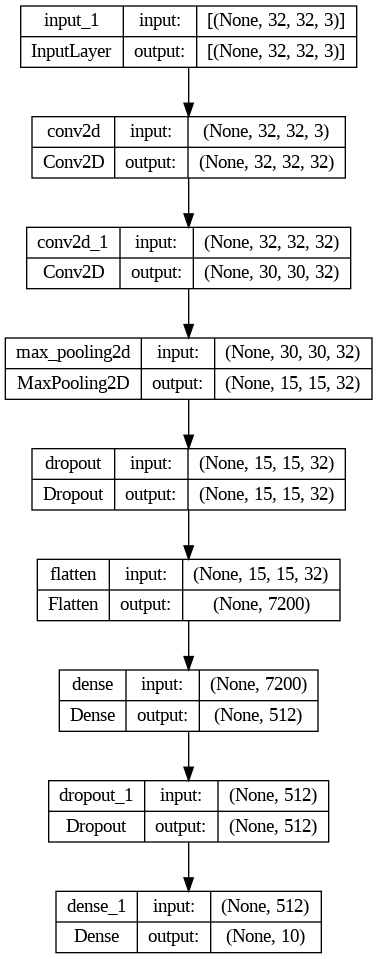

In [21]:
keras.utils.plot_model(model, show_shapes=True)

## Compilar y visualizar

Una vez que hemos definido nuestro modelo, es necesario que lo "compilemos", entonces Keras creará el grafo computacional en TensorFlow de acuerdo a como lo hemos definido.

In [19]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
early_stopping_cb=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

Podemos acceder a los diferentes Layers, mediante el atributo ``.layers``

In [20]:
model.layers

Un buen desafio aca es interpretar los shapes y ver que estan bien.

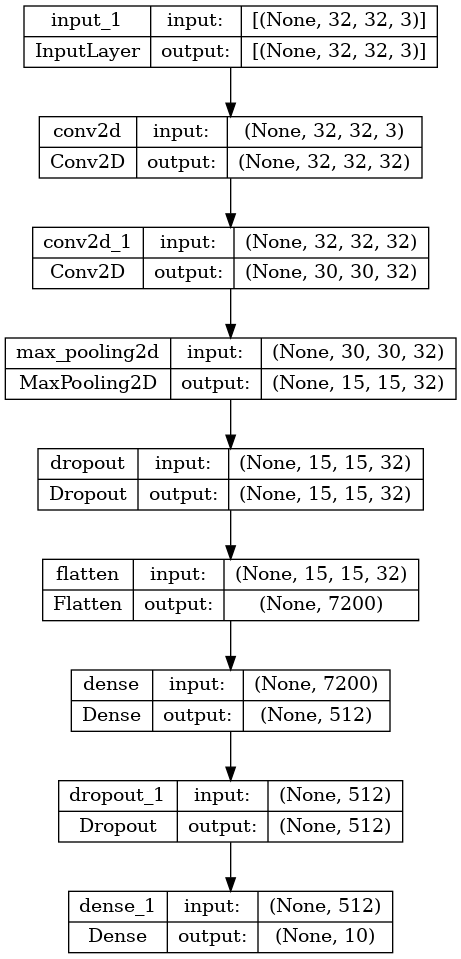

In [21]:
keras.utils.plot_model(model, "my_cifar_cnn.png", show_shapes=True)

## Entrenar

Entrenar es tan facil como hacer un ``.fit``, donde podemos especificar muchas cosas como épocas, datos de validación (que evaluará al final de cada época), métricas, etc.

El método devuelve un objeto de Historia, con toda la información del entrenamiento (en forma de diccionarios), que podremos utilizar para analizar el modelo.

In [22]:
#-----------------------------
#achico todo como para que corra para la clase y encima solo 10 épocas
#todo esto solo para mostrar, después sáquenselo y acomoden

X_train_small = X_train[:5000]
y_train_small = y_train[:5000]

X_valid_small  = X_valid[:1000]
y_valid_small = y_valid[:1000]

#-----------------------------

#history = model.fit(X_train, y_train[:,0], epochs=10,batch_size=32,
#                    validation_data=(X_valid, y_valid[:,0]),callbacks=[early_stopping_cb])


history = model.fit(X_train_small, y_train_small[:,0], epochs=10,batch_size=32,
                    validation_data=(X_valid_small, y_valid_small[:,0]),callbacks=[early_stopping_cb])


Epoch 1/10
157/157 [==============================] - 2s 8ms/step - loss: 2.2627 - accuracy: 0.1526 - val_loss: 2.1706 - val_accuracy: 0.2470
Epoch 2/10
157/157 [==============================] - 1s 6ms/step - loss: 2.1152 - accuracy: 0.2258 - val_loss: 2.0061 - val_accuracy: 0.2940
Epoch 3/10
157/157 [==============================] - 1s 6ms/step - loss: 2.0395 - accuracy: 0.2634 - val_loss: 1.9645 - val_accuracy: 0.2960
Epoch 4/10
157/157 [==============================] - 1s 6ms/step - loss: 1.9879 - accuracy: 0.2886 - val_loss: 1.9184 - val_accuracy: 0.3150
Epoch 5/10
157/157 [==============================] - 1s 6ms/step - loss: 1.9410 - accuracy: 0.3108 - val_loss: 1.8557 - val_accuracy: 0.3240
Epoch 6/10
157/157 [==============================] - 1s 6ms/step - loss: 1.8897 - accuracy: 0.3346 - val_loss: 1.8581 - val_accuracy: 0.3450
Epoch 7/10
157/157 [==============================] - 1s 6ms/step - loss: 1.8582 - accuracy: 0.3416 - val_loss: 1.8663 - val_accuracy: 0.3200
Epoch 

Examinemos el diccionario de parámetros del fit:

In [26]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 157}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Podemos usar el atributo "history" que nos da un diccionario, para plotear las métricas que usamos.

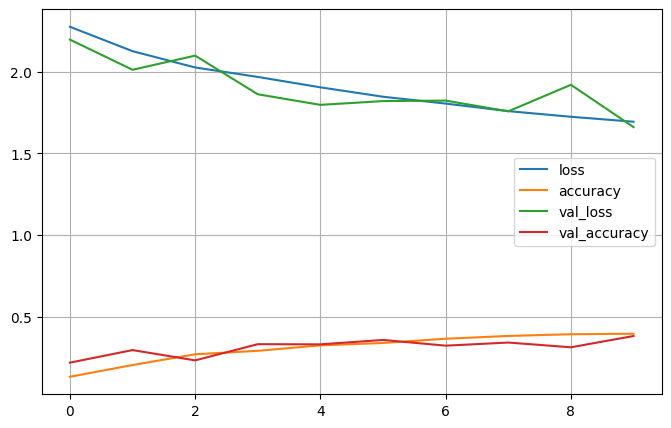

In [28]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

## Evaluar y predecir

Evaluar en un conjunto de Test, o hacer predicciones, es sumamente fácil:

In [29]:
model.evaluate(X_test, y_test[:,0])

313/313 [==============================] - 10s 31ms/step - loss: 1.6726 - accuracy: 0.4028


[1.6725860834121704, 0.4027999937534332]

In [30]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 114ms/step


array([[0.03, 0.02, 0.1 , 0.46, 0.04, 0.25, 0.05, 0.01, 0.03, 0.01],
       [0.07, 0.14, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.63, 0.15],
       [0.09, 0.05, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.75, 0.06]],
      dtype=float32)

In [31]:
y_pred = np.argmax(y_proba, axis=-1)
y_pred

array([3, 8, 8])

In [32]:
np.array(class_names)[y_pred]

array(['Gato', 'Barco', 'Barco'], dtype='<U7')

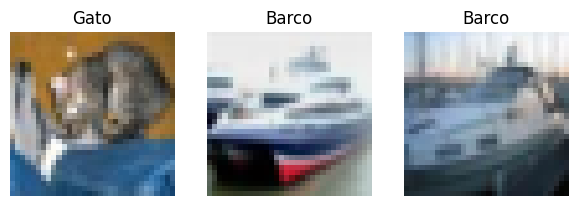

In [33]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index][0]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Guardar y Cargar Modelos

Guardar modelos es tan sencillo como hacer

In [34]:
model.save("my_keras_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Que luego se puede cargar (por ejemplo en otra computadora, con otro script, para hacer predicciones) usando:

In [35]:
model = keras.models.load_model("my_keras_model.h5")

También podemos guardar solamente los weights de los layers. Pero en este caso deberemos, antes de cargarlos, definir el mismo modelo que usamos y recien entonces cargar los weights

In [36]:
model.save_weights("my_keras_weights.ckpt")

In [37]:
model.load_weights("my_keras_weights.ckpt")

# Un uso más inteligente de los parámetros

Recreemos el modelo, para comparar los resultados

In [38]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [39]:
# Input Layer
input_ = keras.layers.Input(shape=X_train.shape[1:])

#---Esto es igual que antes
conv1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_)
conv2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3),  padding='valid',activation='relu')(conv1)
# Capa MaxPool
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
# Dropout
dropout1 = keras.layers.Dropout(0.25)(pool1)
#---
conv1_2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(dropout1)
conv2_2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3),  padding='valid',activation='relu')(conv1_2)

# Capa MaxPool
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2_2)

# Dropout
dropout2 = keras.layers.Dropout(0.25)(pool2)

# Flatten y fully-connected
flatten = keras.layers.Flatten()(dropout2)

hidden1 = keras.layers.Dense(512, activation="relu")(flatten)
dropout2 = keras.layers.Dropout(0.5)(hidden1)

# Capa de salida
output = keras.layers.Dense(10, activation="softmax")(dropout2)

# Define el modelo
model_1 = keras.models.Model(inputs=[input_], outputs=[output])

In [40]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                             

Obsérvese que este modelo tiene menos de la mitad de parámetros que el anterior.

In [41]:
model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [42]:
early = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss',
                                      restore_best_weights=True)

batch_size= 32
epochs = 10

model_1.fit(X_train_small, y_train_small[:,0], batch_size=batch_size, epochs=epochs,
            validation_data=(X_valid_small, y_valid_small[:, 0]),
            callbacks=[early])


Epoch 1/10
157/157 [==============================] - 25s 153ms/step - loss: 2.3025 - accuracy: 0.0968 - val_loss: 2.2943 - val_accuracy: 0.1540
Epoch 2/10
157/157 [==============================] - 24s 151ms/step - loss: 2.2832 - accuracy: 0.1256 - val_loss: 2.2600 - val_accuracy: 0.2180
Epoch 3/10
157/157 [==============================] - 24s 151ms/step - loss: 2.2109 - accuracy: 0.1794 - val_loss: 2.1383 - val_accuracy: 0.1970
Epoch 4/10
157/157 [==============================] - 22s 143ms/step - loss: 2.1230 - accuracy: 0.2068 - val_loss: 2.0775 - val_accuracy: 0.2480
Epoch 5/10
157/157 [==============================] - 24s 151ms/step - loss: 2.0728 - accuracy: 0.2358 - val_loss: 1.9661 - val_accuracy: 0.2650
Epoch 6/10
157/157 [==============================] - 23s 150ms/step - loss: 2.0489 - accuracy: 0.2498 - val_loss: 1.9540 - val_accuracy: 0.2800
Epoch 7/10
157/157 [==============================] - 25s 157ms/step - loss: 2.0299 - accuracy: 0.2604 - val_loss: 1.9978 - val_ac

## Data Augmentation


Una parte importante del problema que tiene la red para aprender a clasificar correctamente los dígitos son ciertas simetrías. Esto también es cierto para muchos problemas en el reconocimiento de imágenes.

En otras palabras, si un número "3" se rotó o desplazó ligeramente, aún deberíamos poder reconocerlo como un tres. Una forma de que la red entienda estas simetrías es alimentarla con una versión transformada de los mismos.

Al mismo tiempo, esto permite aumentar el tamaño del conjunto de entrenamiento.

In [46]:
keras.preprocessing.image.ImageDataGenerator?

- featurewise_center: Booleano que centra los datos alrededor de la medicion promedio en cada feature (o pixel).
- samplewise_center: Booleano que fija la media de una medicion en cero.
- featurewise_std_normalization: Booleano que escalea a cada feature por la varianza en el dataset.
- samplewise_std_normalization: Booleano qie escalea a la medicion para que tenga varianza 1.
- zca_whitening: Boolean. Aplicar o no ZCA whitening.
- zca_epsilon: Aplica ZCA whitening. El default es 1e-6.
- rotation_range: Entero que delimita el rango de las rotaciones al azar (0 a 180).
- width_shift_range: fraccion del ancho que se puede trasladar al azar horizontalmente.
- height_shift_range: fraccion de la altura que se puede trasladar al azar verticalmente.
- brightness_range: Rango de shifteo de brillo.
- shear_range: Rango de shear al azar (el angulo se mide en grados en sentido contrario a las agujas del reloj). Se refleja en intensidad de angulo de corte.
- zoom_range: Rango de zoom al azar.
- channel_shift_range: Rango de cambios al azar de canal.
- fill_mode: {"constant", "nearest", "reflect" or "wrap"}. El default es 'nearest'. Forma de rellenar imagenes para llegar a determinado shape.
- cval: Valor de relleno si se elige fill_mode = "constant".
- horizontal_flip: Booleano: invierte horizontalmente al azar.
- vertical_flip: Booleano: invierte verticalmente al azar.
- rescale: rescaleo de todos los inputs. Por defecto es None (0 es equivalente a None).
- preprocessing_function: funcion de preprocesado aplicada a cada imagen luego de cambiarle el tamanio y las otras aumentaciones.
- data_format: formato de datos.
- validation_split: fraccion reservada para validacion.
- dtype: el dtype de los arrays generados.

Y se utiliza de la siguiente manera:

In [47]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train_small)

Para ajustar un modelo con aumento de datos, tenemos que sustituir la llamada a `.fit` por:

In [48]:
cancbatch_size = 1000
epochs = 10

model.fit_generator(datagen.flow(X_train_small, y_train_small[:,0], batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_valid_small, y_valid_small[:, 0]),
                    callbacks=[early, tensorboard_callback])



<ipython-input-48-777e5de15f8a>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(X_train_small, y_train_small[:,0], batch_size=batch_size),


Epoch 1/10
5/5 [==============================] - 21s 4s/step - loss: 1.7512 - accuracy: 0.3720 - val_loss: 1.5926 - val_accuracy: 0.4260
Epoch 2/10
5/5 [==============================] - 19s 3s/step - loss: 1.7278 - accuracy: 0.3816 - val_loss: 1.5868 - val_accuracy: 0.4400
Epoch 3/10
5/5 [==============================] - 18s 4s/step - loss: 1.7164 - accuracy: 0.3918 - val_loss: 1.5887 - val_accuracy: 0.4280
Epoch 4/10
5/5 [==============================] - 20s 4s/step - loss: 1.7105 - accuracy: 0.3844 - val_loss: 1.5824 - val_accuracy: 0.4310
Epoch 5/10
5/5 [==============================] - 18s 4s/step - loss: 1.7081 - accuracy: 0.3920 - val_loss: 1.5830 - val_accuracy: 0.4270
Epoch 6/10
5/5 [==============================] - 20s 4s/step - loss: 1.7087 - accuracy: 0.3894 - val_loss: 1.5816 - val_accuracy: 0.4300
Epoch 7/10
5/5 [==============================] - 18s 3s/step - loss: 1.7084 - accuracy: 0.3930 - val_loss: 1.5801 - val_accuracy: 0.4290
Epoch 8/10
5/5 [==================